In [1]:
import os
import time
from collections import deque
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

import utilities

Features to add:
- add item_category, shop_id, and item_id as features
- encode these categorical vars: mean encode - HOW?
    - most successfull one in the homework was expanding mean scheme. - suggests I need lagged features too

- create a feature that bins shops into groups based on net income
    - perhaps net income by category of item
- create feature that bins shops into groups based on seasonal pattern (spectral biclustering?)
- similarly create a feature that groups products based on seasonal pattern
- need to add date indicators:
    * perhaps group months into high holiday/low holiday count
    * perhaps number of days in month
    * number of weekend days vs week days
- create features based on lagged behavior
    * rolling windows sum/variance (last 3 mos, last 6 months, last year)
    * can do this for each item, or can use this as an encoding of shop, and category ids


In [2]:
sales = utilities.load_and_preprocess()

# Pre processing

In [3]:
agg_sales = utilities.aggregate_monthly(sales)
piv_agg_sales = agg_sales.set_index(['Month', 'shop_id', 'item_id']).item_cnt_month.unstack(level=0).fillna(0)

In [4]:
stacked = piv_agg_sales.stack()

In [5]:
stacked[stacked !=0].describe()

count    1.606541e+06
mean     2.270845e+00
std      8.656355e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.253000e+03
dtype: float64

In [6]:
stacked.sort_values()

shop_id  item_id  Month  
12       8023     2013-11     -22.0
         1590     2013-01     -13.0
         1593     2013-01      -6.0
         11367    2014-08      -5.0
         3732     2013-11      -4.0
                              ...  
55       3730     2015-04    1242.0
31       20949    2013-12    1305.0
55       9249     2015-09    1644.0
12       9248     2015-09    1644.0
         11373    2015-10    2253.0
Length: 14420216, dtype: float64

In [7]:
preprocessed_data = np.clip(piv_agg_sales, 0, 20)

In [8]:
preprocessed_data.stack().sort_values()

shop_id  item_id  Month  
0        30       2013-01     0.0
41       17063    2015-02     0.0
                  2015-03     0.0
                  2015-04     0.0
                  2015-05     0.0
                             ... 
25       4084     2015-06    20.0
14       2308     2015-06    20.0
22       3329     2014-02    20.0
9        15284    2014-10    20.0
51       2814     2014-04    20.0
Length: 14420216, dtype: float64

# Feature generation

In [9]:
target_encode_items = preprocessed_data.groupby(level=1).transform('sum')
target_encode_shops = preprocessed_data.groupby(level=0).transform('sum')

In [10]:
%%time
half_lifes = [3,6,9,12]
sales_ewms_mean = {tau:preprocessed_data.ewm(halflife=6, axis=1, min_periods=tau).mean() for tau in half_lifes}
sales_ewms_std = {tau:preprocessed_data.ewm(halflife=6, axis=1, min_periods=tau).std() for tau in half_lifes}
items_ewms = {tau:target_encode_items.ewm(halflife=6, axis=1, min_periods=tau).mean() for tau in half_lifes}
shops_ewms = {tau:target_encode_shops.ewm(halflife=6, axis=1, min_periods=tau).mean() for tau in half_lifes}

Wall time: 38.5 s


In [11]:
all_months = preprocessed_data.columns.tolist()
full_data_monts = all_months[11:-1]

In [12]:
sales_mean_features = {f'sales_ewms_mean_{tau}': sales_ewms_mean[tau] for tau in half_lifes}
sales_std_features = {f'sales_ewms_std_{tau}': sales_ewms_std[tau] for tau in half_lifes}
items_features = {f'items_ewms_{tau}': items_ewms[tau] for tau in half_lifes}
shops_features = {f'shops_ewms_{tau}': shops_ewms[tau] for tau in half_lifes}

features_dict = {**sales_mean_features, **sales_std_features, **items_features, **shops_features}

# Note that I use raw-data for objective 
objectives = piv_agg_sales.shift(-1, axis=1)

In [13]:
def get_single_month_XY(month_):
    cols = [df[month_].rename(name) for (name, df) in features_dict.items()]
    X = pd.concat(cols, axis=1)
    Y = objectives[month_]
    
    # might turn this into separate function to pass into here
    X['month'] = month_.month
    X['season'] = X.month.map({1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:1, 8:2, 9:2, 10:2, 11:3, 12:3})
    
    return X,Y

In [14]:
tempx, tempy = get_single_month_XY(all_months[-1])

In [15]:
tempx.head()

sales_ewms_mean_3  sales_ewms_mean_6  sales_ewms_mean_9  \
shop_id item_id                                                            
0       30                0.055208           0.055208           0.055208   
        31                0.030364           0.030364           0.030364   
        32                0.042359           0.042359           0.042359   
        33                0.015659           0.015659           0.015659   
        35                0.041105           0.041105           0.041105   

                 sales_ewms_mean_12  sales_ewms_std_3  sales_ewms_std_6  \
shop_id item_id                                                           
0       30                 0.055208          1.082319          1.082319   
        31                 0.030364          0.595275          0.595275   
        32                 0.042359          0.621241          0.621241   
        33                 0.015659          0.222969          0.222969   
        35                 0.041105          0.759210          0.759210   

                 sales_ewms_std_9  sales_ewms_std_12  items_ewms_3  \
shop_id item_id                                                      
0       30               1.082319           1.082319     12.546831   
        31               0.595275           0.595275     18.898858   
        32               0.621241           0.621241     31.954147   
        33               0.222969           0.222969     17.680996   
        35               0.759210           0.759210      0.628753   

                 items_ewms_6  items_ewms_9  items_ewms_12  shops_ewms_3  \
shop_id item_id                                                            
0       30          12.546831     12.546831      12.546831      29.37242   
        31          18.898858     18.898858      18.898858      29.37242   
        32          31.954147     31.954147      31.954147      29.37242   
        33          17.680996     17.680996      17.680996      29.37242   
        35           0.628753      0.628753       0.628753      29.37242   

                 shops_ewms_6  shops_ewms_9  shops_ewms_12  month  season  
shop_id item_id                                                            
0       30           29.37242      29.37242       29.37242     10       2  
        31           29.37242      29.37242       29.37242     10       2  
        32           29.37242      29.37242       29.37242     10       2  
        33           29.37242      29.37242       29.37242     10       2  
        35           29.37242      29.37242       29.37242     10       2

# Fitting and CV

In [16]:
def fit_and_predict(model, x_train, y_train, x_val = None):
    
    start_time = time.time()
    fitted_model = model.fit(x_train, y_train)
    fit_time = time.time() - start_time
    
    y_train_pred = fitted_model.predict(x_train)
    
    if x_val is not None:
        y_val_pred = fitted_model.predict(x_val)
    else:
        y_val_pred = None
        
    
    return fitted_model, y_train_pred, y_val_pred, fit_time
    

In [17]:
month = full_data_monts[0]
X_train,Y_train = get_single_month_XY(full_data_monts[0])
X_val,Y_val = get_single_month_XY(full_data_monts[1])

In [18]:
mod = RandomForestRegressor(n_estimators=50, max_depth=5, n_jobs=-1)
fitted, ytpred, yvpred, elapsed = fit_and_predict(mod, X_train,Y_train, X_val)
elapsed, mean_squared_error(Y_train, ytpred), mean_squared_error(Y_val, yvpred)

(20.569006204605103, 1.0607640561519311, 2.370211284000684)

In [27]:
import xgboost as xgb

class xgb_model:
    def __init__(self, num_boost_round, **params):
        self.params = {
            'num_boost_round': num_boost_round,
            'max_depth':6,
            'min_child_weight': 1,
            'eta':.3,
            'subsample': 1,
            'colsample_bytree': 1,
            'objective':'reg:squarederror',
        }
        self.params.update(params)
        self.fitted_model = None
       
    def fit(self, X, Y):
        dm_train = xgb.DMatrix(X,Y)
        self.fitted_model = xgb.train(self.params, dtrain=dm_train)
        return self
    
    def predict(self, X):
        assert self.fitted_model is not None, 'Must fit first'
        dm = xgb.DMatrix(X)
        return self.fitted_model.predict(dm)
    
    def feature_importances_(self):
        pass

In [33]:
mod = xgb_model(num_boost_round=100, max_depth=10, eta=0.1)
fitted, ytpred, yvpred, elapsed = fit_and_predict(mod, X_train,Y_train, X_val)
elapsed, mean_squared_error(Y_train, ytpred), mean_squared_error(Y_val, yvpred)

(1.347395896911621, 2.1891927441110517, 2.793042957848449)

In [77]:
def rolling_cross_validation(model, data_months_list, validate_months_num=None, num_stack_months=1, fit_final=False):
    Xs_deque = deque()
    Ys_deque = deque()
    
    for month in data_months_list[:num_stack_months]:
        X_, Y_ = get_single_month_XY(month)
        Xs_deque.append(X_)
        Ys_deque.append(Y_)
        
    if validate_months_num is None:
        validate_months_num = len(data_months_list) - num_stack_months
    else:
        validate_months_num = min(validate_months_num, len(data_months_list) - num_stack_months)
        
    
    fitted_models = {}
    in_sample_scores = {}
    oos_scores = {}
    loop_times = []
    
    for month in data_months_list[num_stack_months: num_stack_months + validate_months_num]:
        print(f'Working on: {month}')
        loop_start = time.time()
        X_train = pd.concat(Xs_deque)
        Y_train = pd.concat(Ys_deque)
        
        X_val, Y_val = get_single_month_XY(month)
        fitted, ytrain_pred, yval_pred, elapsed_time = fit_and_predict(model, X_train, Y_train, X_val)
        fitted_models[month] = fitted
        print(f'fit time: {elapsed_time}')
        
        in_sample_scores[month] = mean_squared_error(Y_train, ytrain_pred)
        oos_scores[month] = mean_squared_error(Y_val, yval_pred)
        
        Xs_deque.popleft()
        Ys_deque.popleft()
        
        Xs_deque.append(X_val)
        Ys_deque.append(Y_val)
        
        loop_end = time.time()
        loop_times.append(loop_end - loop_start)
    
    if fit_final:
        X_train = pd.concat(Xs_deque)
        Y_train = pd.concat(Ys_deque)
        fitted, ytrain_pred, yval_pred, elapsed_time = fit_and_predict(model, X_train, Y_train, X_val)
        fitted_models['FINAL'] = fitted
        in_sample_scores['FINAL'] = mean_squared_error(Y_train, ytrain_pred)
    
    
    return fitted_models, in_sample_scores, oos_scores, loop_times

In [31]:
mod = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=5)
fitted_models, isscores, osscores, times = rolling_cross_validation(mod, full_data_monts[-14:], num_stack_months=12, fit_final=True)

Working on: 2015-08
fit time: 1586.9039380550385
Working on: 2015-09
fit time: 1547.0298216342926


In [32]:
fitted_models

{Period('2015-08', 'M'): RandomForestRegressor(max_depth=10, n_jobs=5),
 Period('2015-09', 'M'): RandomForestRegressor(max_depth=10, n_jobs=5),
 'FINAL': RandomForestRegressor(max_depth=10, n_jobs=5)}

In [33]:
pd.Series(isscores)

2015-08    3.121010
2015-09    3.219742
FINAL      2.961585
dtype: float64

In [34]:
pd.Series(osscores)

2015-08    22.363004
2015-09    14.302401
Freq: M, dtype: float64

In [43]:
all_months[-1]

Period('2015-10', 'M')

In [40]:
X,Y = get_single_month_XY(all_months[-1])

In [42]:
X

sales_ewms_3  sales_ewms_6  sales_ewms_9  sales_ewms_12  \
shop_id item_id                                                            
0       30           0.085572      0.085572      0.085572       0.085572   
        31           0.030364      0.030364      0.030364       0.030364   
        32           0.042359      0.042359      0.042359       0.042359   
        33           0.015659      0.015659      0.015659       0.015659   
        35           0.041105      0.041105      0.041105       0.041105   
...                       ...           ...           ...            ...   
59      22154        0.002459      0.002459      0.002459       0.002459   
        22155        0.004918      0.004918      0.004918       0.004918   
        22162        0.802237      0.802237      0.802237       0.802237   
        22164        0.327895      0.327895      0.327895       0.327895   
        22167        0.042011      0.042011      0.042011       0.042011   

                 items_ewms_3  items_ewms_6  items_ewms_9  items_ewms_12  \
shop_id item_id                                                            
0       30          30.630554     30.630554     30.630554      30.630554   
        31          30.630554     30.630554     30.630554      30.630554   
        32          30.630554     30.630554     30.630554      30.630554   
        33          30.630554     30.630554     30.630554      30.630554   
        35          30.630554     30.630554     30.630554      30.630554   
...                       ...           ...           ...            ...   
59      22154     1156.030739   1156.030739   1156.030739    1156.030739   
        22155     1156.030739   1156.030739   1156.030739    1156.030739   
        22162     1156.030739   1156.030739   1156.030739    1156.030739   
        22164     1156.030739   1156.030739   1156.030739    1156.030739   
        22167     1156.030739   1156.030739   1156.030739    1156.030739   

                 shops_ewms_3  shops_ewms_6  shops_ewms_9  shops_ewms_12  \
shop_id item_id                                                            
0       30          13.735327     13.735327     13.735327      13.735327   
        31          19.191109     19.191109     19.191109      19.191109   
        32          32.099844     32.099844     32.099844      32.099844   
        33          17.680996     17.680996     17.680996      17.680996   
        35           0.628753      0.628753      0.628753       0.628753   
...                       ...           ...           ...            ...   
59      22154        2.236950      2.236950      2.236950       2.236950   
        22155        0.655660      0.655660      0.655660       0.655660   
        22162       36.610305     36.610305     36.610305      36.610305   
        22164       25.957408     25.957408     25.957408      25.957408   
        22167       37.483077     37.483077     37.483077      37.483077   

                 month  season  
shop_id item_id                 
0       30          10       2  
        31          10       2  
        32          10       2  
        33          10       2  
        35          10       2  
...                ...     ...  
59      22154       10       2  
        22155       10       2  
        22162       10       2  
        22164       10       2  
        22167       10       2  

[424124 rows x 14 columns]

In [46]:
predictions = fitted_models['FINAL'].predict(X)

In [50]:
predictions = pd.DataFrame({'item_cnt_month':predictions}, index=X.index)

In [54]:
utilities.merge_pred_with_test(predictions).to_csv('2020_08_25_month_stacked_RF_with_ewms.csv')

# Analysis

In [105]:
def plot_feature_importances(mod, col_names, figsize=(6,10)):
    plt.figure(figsize=figsize)
    pd.Series(mod.feature_importances_, index=col_names).sort_values().plot(kind='barh')

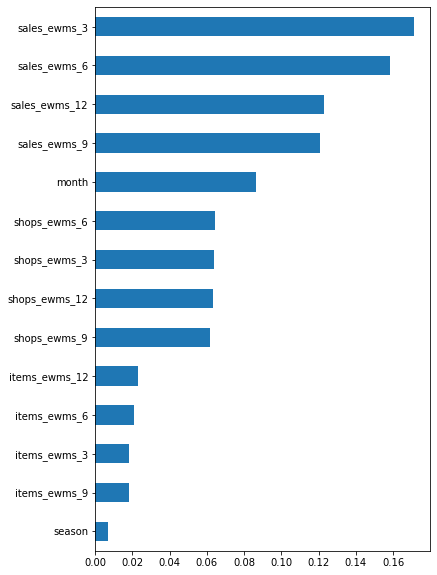

In [106]:
plot_feature_importances(fitted_models['FINAL'], X_train.columns)

Other code